# Evaluate variation in power across similar values for k

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cna
fig_dir = "/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"

ks_by_type = {"Myeloid": [3,24], "NK": [3,17], "T": [4,33], "B": [2,15], "allcells": [6,49]}

In [2]:
def min_p_vals_by_locus(min_p_min_thresh, min_p_max_thresh, max_k=50, min_snps = 2):
    all_p_vals = np.array([])
    celltypes=[]
    for celltype in ["Myeloid", "NK", "B", "T", "allcells"]:
        
        # Import the GeNA result for each value of k between 1 and 50 for each simulate
        res = pd.read_csv("/data/srlab/lrumker/MCSC_Project/cna-qtl/results/k_sensitivity/gwas_"+\
                          celltype+"_nonnull_sims/P_k_t_sugg_snps.txt", delim_whitespace=True, header = None)

        colnames = np.concatenate([["min_P", "min_P_k", "CHR", "POS", "ID", "REF", "ALT", "EFFECT", "ADD", "N", 
                       "min_P_dup", "min_P_k_dup"], ["B"+str(i+1) for i in np.arange(max_k)]])
        colnames = np.concatenate([colnames, ["T"+str(i+1) for i in np.arange(max_k)]])
        res.columns = np.concatenate([colnames, ["k"+str(i+1)+"_P" for i in np.arange(max_k)]])
        res.drop(columns=["min_P_dup", "min_P_k_dup"], inplace = True)
        meta = pd.read_table("/data/srlab/lrumker/MCSC_Project/cna-qtl/nonnull_sims/sim_genotypes/"+\
                             celltype+"_sim_genotypes_meta.tsv")
        
        # Retain only simulates that attain p<5e-8 for some value of k
        P_vals = res.loc[:,["k"+str(i+1)+"_P" for i in np.arange(max_k)]]
        keep_snps = np.where(np.min(P_vals, 1).values<5e-8)[0]
        meta = meta.iloc[keep_snps,:].reset_index(drop = True)
        res = res.iloc[keep_snps,:].reset_index(drop = True)
        
        # Retain a single simulate at random for each trait from among all the simulates
        # that explain 5-12% of variance in the phenotype
        retained_snps = np.array([])
        max_varexpl = 0.12
        min_varexpl = 0.05
        for trait in meta.trait.value_counts().index.tolist():
            trait_indices = np.where(meta.trait==trait)[0]
            trait_indices = trait_indices[np.logical_and(meta.varexpl[trait_indices]<=max_varexpl, 
                       meta.varexpl[trait_indices]>=min_varexpl)]
            if trait_indices.shape[0]==0: continue
            retained_snps = np.concatenate([retained_snps, [np.random.choice(trait_indices)]])
        res = res.iloc[retained_snps,:]

        # Export the GeNA p-values for this SNP for each value of k
        P_vals = res.loc[:,["k"+str(i+1)+"_P" for i in np.arange(max_k)]]
        if all_p_vals.shape[0]==0:
            all_p_vals = P_vals
            celltypes = np.repeat(celltype,P_vals.shape[0])
        else:
            all_p_vals = np.vstack([all_p_vals, P_vals])
            celltypes = np.concatenate([celltypes, np.repeat(celltype,P_vals.shape[0])])
    return all_p_vals, celltypes

In [3]:
plot_thresh = 1e-6
to_plot, celltypes = min_p_vals_by_locus(min_p_min_thresh = 5e-8, min_p_max_thresh = np.nan, min_snps = 0)
to_plot[to_plot>plot_thresh] = np.nan

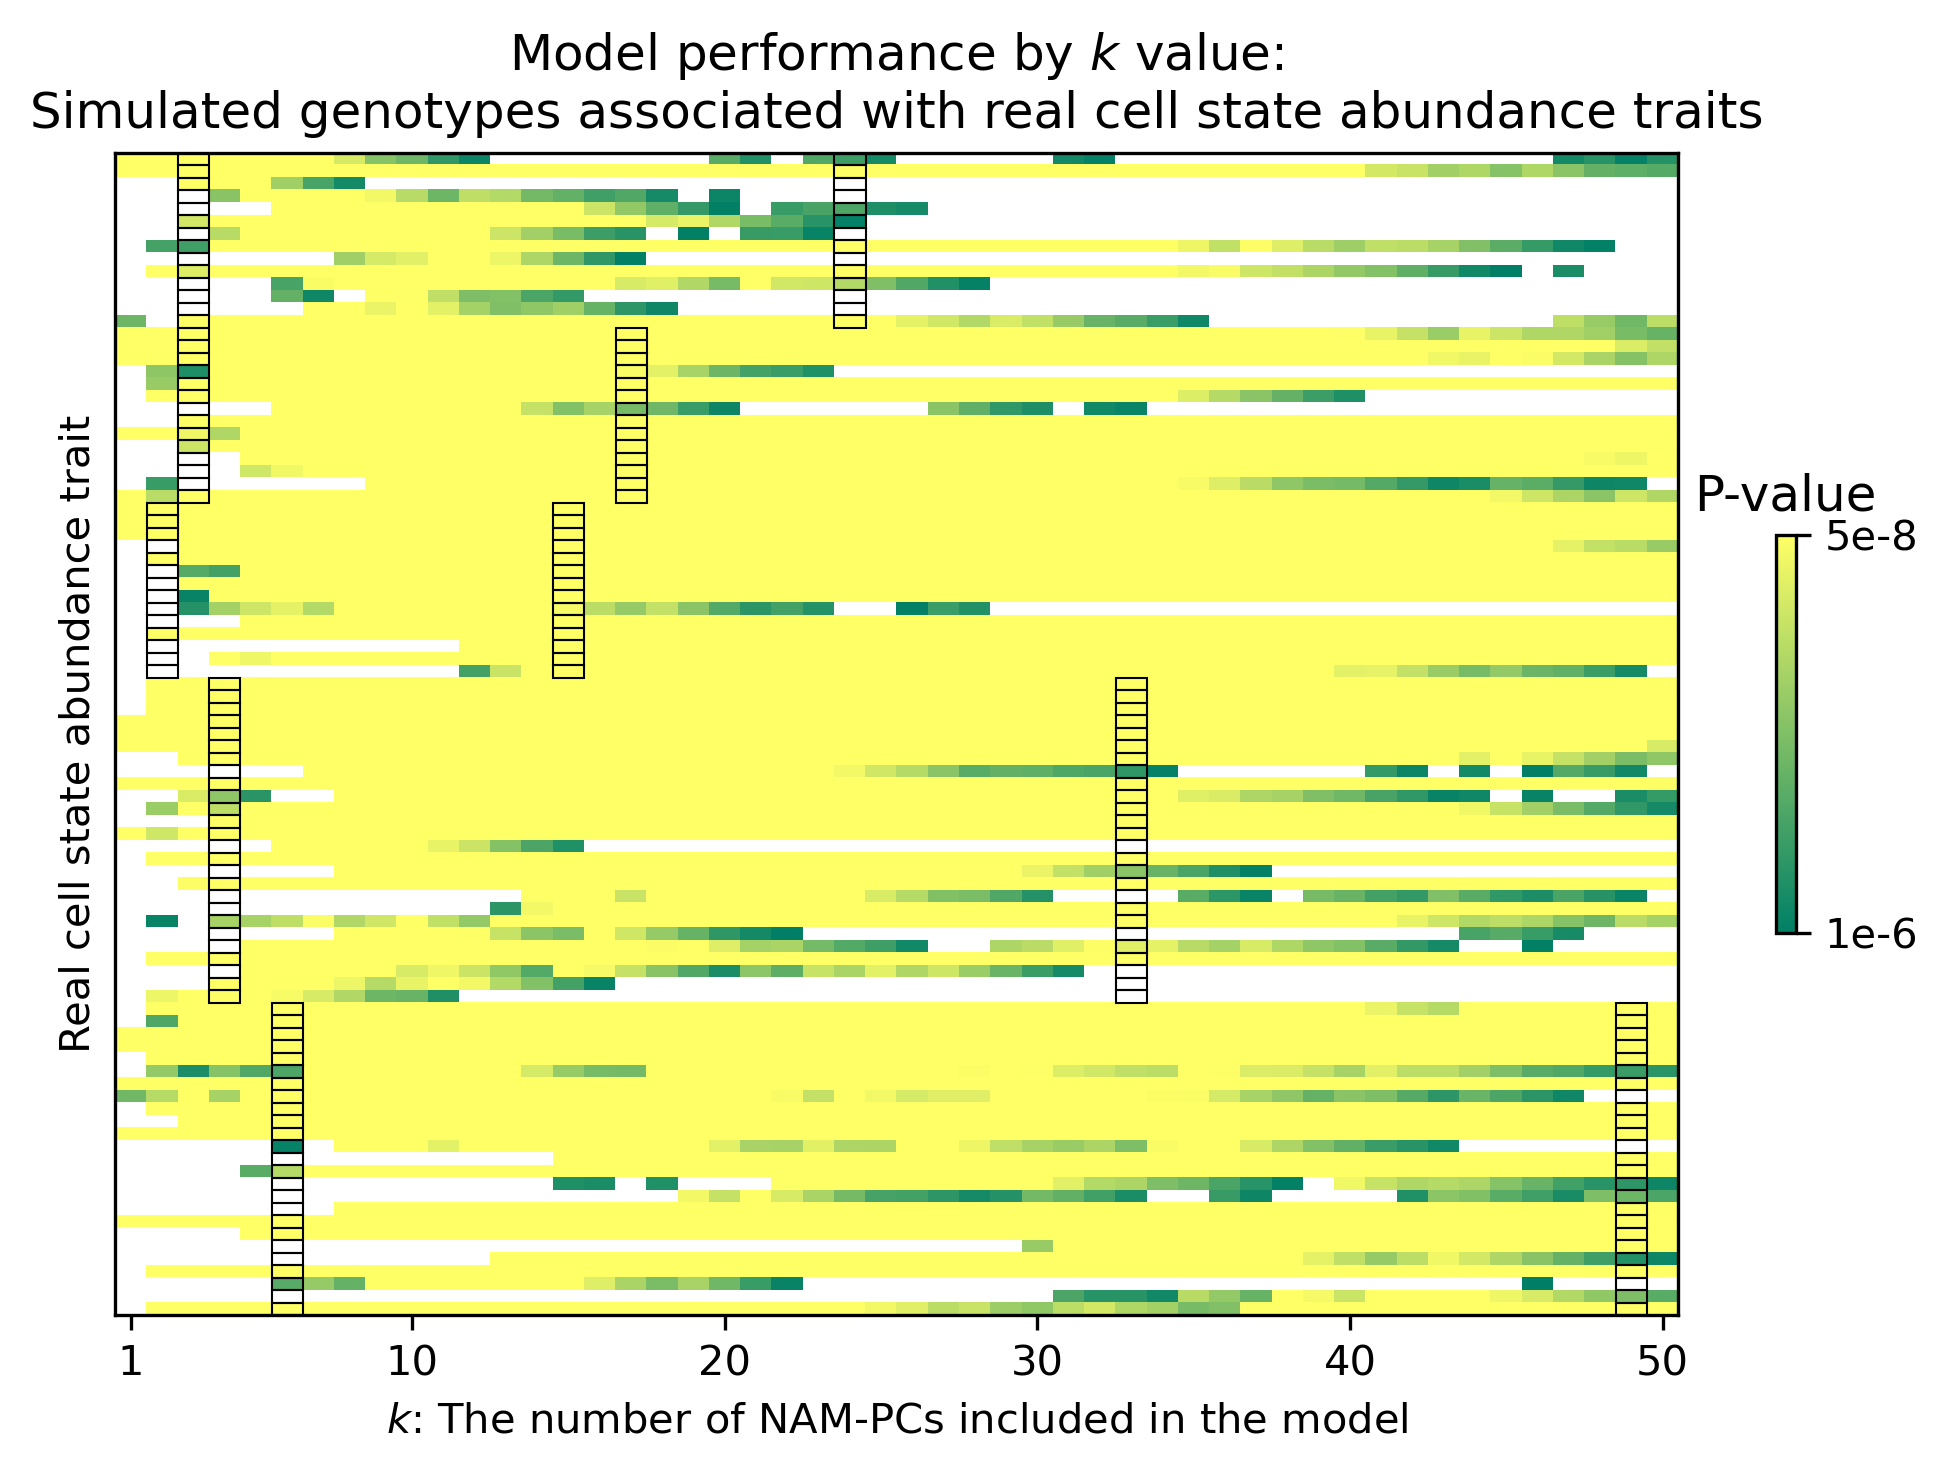

In [4]:
## We examine the variation in performance for models with different values of k (the number of top NAM-PCs
## used to capture total cellular composition per sample). For all cell types we considered k in [1,50]

# We plot results for one simulated SNP per real single-cell cell state abundance trait, selected
# at random among all simulated SNPs that that explain 5-12% of variance in the phenotype and
# attain at least p<5e-8 for any value of k in [1,50]

np.random.seed(0)
fig, ax = plt.subplots(dpi = 300, figsize = (7,5))

im = ax.imshow(-np.log10(to_plot), interpolation='none', cmap = "summer", 
               vmin=-np.log10(1e-6), vmax = -np.log10(5e-8), aspect = 0.4)

for i, celltype in enumerate(celltypes): # mark the selected values of k
    ks = ks_by_type[celltype]
    ax.add_patch(Rectangle((ks[0]-1-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=0.5))
    ax.add_patch(Rectangle((ks[1]-1-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=0.5))

cbar = ax.figure.colorbar(im, ax=ax, shrink=0.3, ticks=[6, -np.log10(5e-8)])
cbar.ax.set_title('P-value')
cbar.ax.set_yticklabels(['1e-6', '5e-8'])

ax.set_title("Model performance by $k$ value:\nSimulated genotypes associated with real cell state abundance traits")
ax.set_xlabel("$k$: The number of NAM-PCs included in the model")
ax.set_xticks([0,9,19,29,39,49])
ax.set_xticklabels((np.array([0,9,19,29,39,49])+1).astype(str))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel("Real cell state abundance trait")
fig.tight_layout()
plt.savefig(fig_dir+"k_sensitivity_nonnull_sims.png", dpi = 300, transparent=True)
plt.show()

# Results for observed csaQTLs in the OneK1K dataset

In [5]:
celltypes=["NK", "NK", "NK", "NK", "Myeloid"]
lead_snps=["11:128070535:A:G", "2:111851212:C:T", "12:10583611:C:T", "19:16441973:G:A", "15:80263217:C:T"]
max_k=50

all_p_vals = np.array([])
for j in np.arange(len(celltypes)):
    celltype=celltypes[j]
    lead_snp=lead_snps[j]

    
    res = pd.read_csv("/data/srlab/lrumker/MCSC_Project/cna-qtl/results/k_sensitivity/gwas_"+\
                      celltype+"/"+lead_snp+"/P_k_t_sugg_snps.txt", delim_whitespace=True, header = None)
    colnames = np.concatenate([["min_P", "min_P_k", "CHR", "POS", "ID", "REF", "ALT", "EFFECT", "ADD", "N", 
                   "min_P_dup", "min_P_k_dup"], ["B"+str(i+1) for i in np.arange(max_k)]])
    colnames = np.concatenate([colnames, ["T"+str(i+1) for i in np.arange(max_k)]])
    res.columns = np.concatenate([colnames, ["k"+str(i+1)+"_P" for i in np.arange(max_k)]])
    res.drop(columns=["min_P_dup", "min_P_k_dup"], inplace = True)
    P_vals = res.loc[:,["k"+str(i+1)+"_P" for i in np.arange(max_k)]]
    
    # Store the minimum p-value across SNPs for each value of k 
    sel_p_vals = P_vals.min(axis=0).values
    if all_p_vals.shape[0]==0:
        all_p_vals = sel_p_vals
    else:
        all_p_vals = np.vstack([all_p_vals, sel_p_vals])

In [6]:
to_plot = all_p_vals
plot_thresh = 1e-6
to_plot[to_plot>plot_thresh] = np.nan

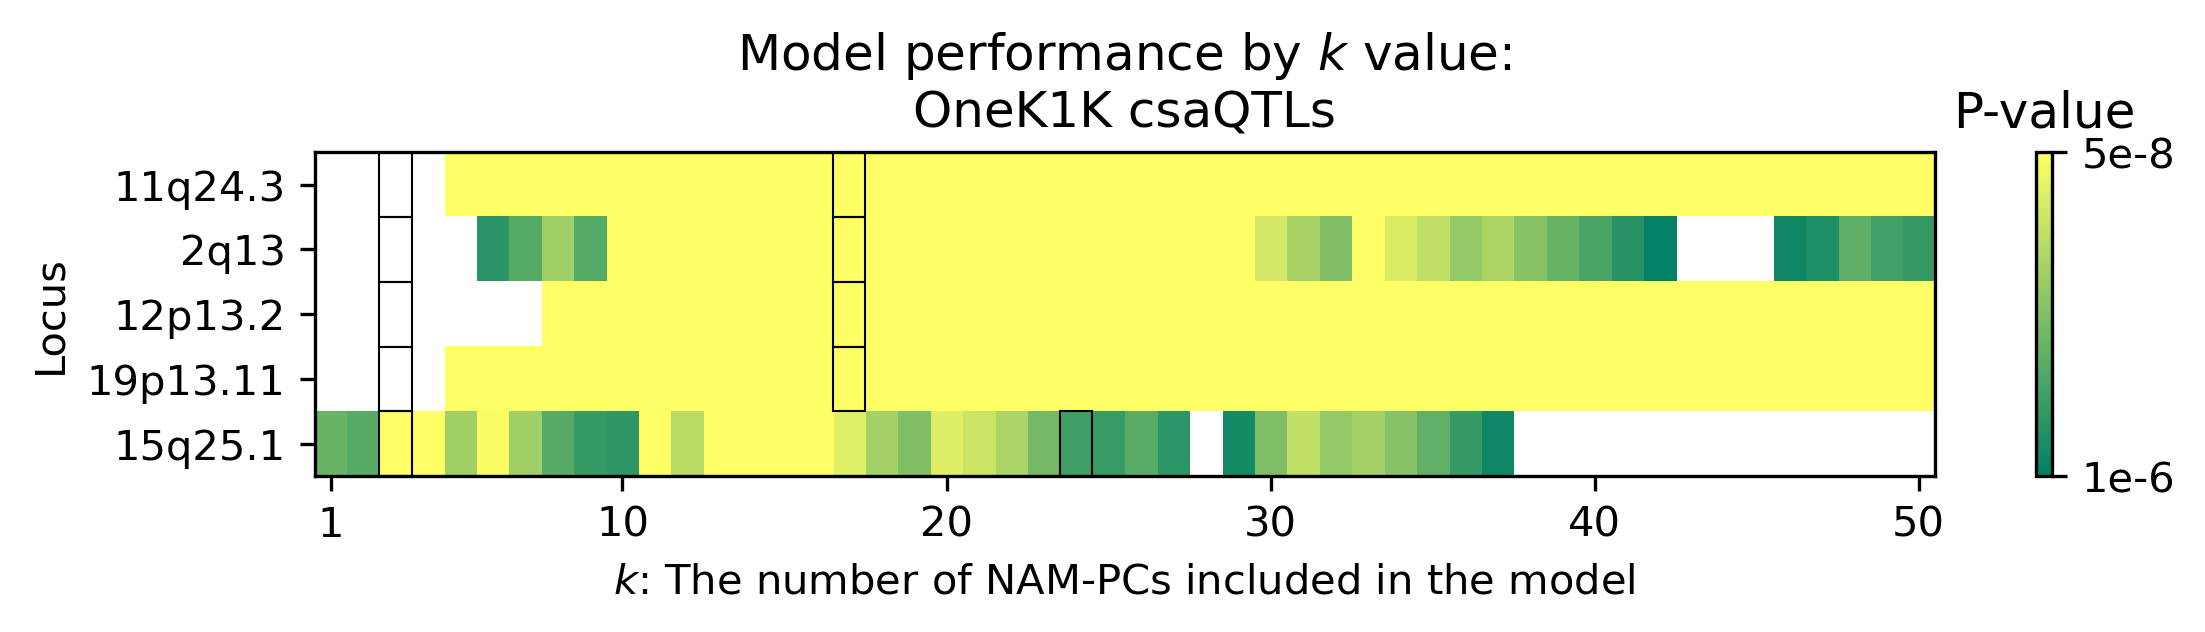

In [7]:
# Only color the heatmap when the locus minimum p-value is less than plot_thresh
fig, ax = plt.subplots(dpi = 300, figsize = (8,3))

# Scale the colorbar to show a dynamic range between 1e-6 and 5e-8
im = ax.imshow(-np.log10(to_plot), interpolation='none', cmap = "summer", 
               vmin=-np.log10(1e-6), vmax = -np.log10(5e-8), aspect = 2)

for i, celltype in enumerate(celltypes): # mark the GeNA default values of k
    ks = ks_by_type[celltype]
    ax.add_patch(Rectangle((ks[0]-1-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=0.5))
    ax.add_patch(Rectangle((ks[1]-1-0.5, i-0.5), 1, 1, fill=False, edgecolor='black', lw=0.5))

cbar = ax.figure.colorbar(im, ax=ax, shrink=0.4, ticks=[6, -np.log10(5e-8)])
cbar.ax.set_title('P-value')
cbar.ax.set_yticklabels(['1e-6', '5e-8'])

ax.set_title("Model performance by $k$ value:\nOneK1K csaQTLs")
ax.set_xlabel("$k$: The number of NAM-PCs included in the model")
ax.set_xticks([0,9,19,29,39,49])
ax.set_xticklabels((np.array([0,9,19,29,39,49])+1).astype(str))
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['11q24.3','2q13', '12p13.2', '19p13.11', '15q25.1'])
ax.set_ylabel("Locus")
fig.tight_layout()
plt.savefig(fig_dir+"k_sensitivity_gw_sig.png", dpi = 300, transparent=True)
plt.show()